In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import pandas as pd
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import multivariate_normal


In [14]:
def typicality(X, typ_epsilon):
    robust_cov = MinCovDet().fit(X)
    cov_est = robust_cov.covariance_
    est_mean = np.mean(X, axis=0)
    est_ent = multivariate_normal(mean=est_mean, cov=cov_est).entropy()
    lo = 2**(-(est_ent - typ_epsilon))
    hi = 2**(-(est_ent + typ_epsilon))
    est_px = multivariate_normal.pdf(X, mean=est_mean, cov=cov_est)
    return lo, hi, est_px

def plot(X, mah_outliers, typ_outliers, typ_inliers, filename='mah_v_typ_2.png'):

    # split into subgroups of classified points
    both_outliers =  np.where((mah_outliers == True)  & (typ_outliers == True))
    just_typ_outliers = np.where((typ_outliers == True) & (mah_outliers == False))
    just_mah_outliers = np.where((typ_outliers == False) & (mah_outliers == True))
    rest = np.where((typ_outliers == False) & (mah_outliers == False))

    custom = [plt.Line2D([], [], marker='o', markersize=12, color='k', linestyle='None'),
              plt.Line2D([], [], marker='|', markersize=20, color='k', linestyle='None'),
              plt.Line2D([], [], marker='s', markersize=12, color='k', linestyle='None'),
              plt.Line2D([], [], marker='^', markersize=12, color='k', linestyle='None'),
              plt.Line2D([], [], marker='_', markersize=20, color='k', linestyle='None')]

    # prep figure
    plt.figure(figsize=(figx,figy))
    plt.rcParams.update({'font.size': 16})

    # First plot both outliers
    plt.scatter(X[both_outliers, 0], X[both_outliers, 1], c=m_dists[both_outliers],
                marker='o', s=130, edgecolor='black')
    # rescale colors to get full range of m_dists across both plots
    plt.clim(0,colorbar_lim)

    # Second plot both inliers
    plt.scatter(X[rest, 0], X[rest, 1], c=m_dists[rest],
                marker='|', s=160)
    plt.clim(0,colorbar_lim)

    # Third plot just Mah outliers
    plt.scatter(X[just_mah_outliers, 0], X[just_mah_outliers, 1], c=m_dists[just_mah_outliers],
                marker='s', s=120, edgecolor='black')
    plt.clim(0,colorbar_lim)


    # Fourth plot just typ outliers
    plt.scatter(X[just_typ_outliers, 0], X[just_typ_outliers, 1], c=m_dists[just_typ_outliers],
                marker='^', s=190, edgecolor='black')
    plt.clim(0,colorbar_lim)

    # Fifth plot just REAL outliers
    plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='k', marker='_',s=140)
    plt.clim(0,colorbar_lim)

    # add color legend
    cbar = plt.colorbar()
    cbar.set_label('MCD Mahalanobis Dist.', rotation=270, labelpad=20)

    plt.grid()
    plt.ylim(minylim , maxylim)
    plt.xlim(minxlim, maxxlim)
    plt.legend(custom, ['Both Outliers', 'Both Inliers', 'Mah. Outliers', 'Typ. Outliers', 'True Outliers'], loc='lower left' ,
               fontsize=15, framealpha=0.0)
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi)
    plt.show()

In [15]:
# GENERAL PARAMETERS
# for consistent results
np.random.seed(42)

n_samples = 140
n_outliers = 15
n_features = 2

gen_cov = np.eye(n_features)
gen_cov[1,0] = 0.5
gen_cov[0,1] = 0.5

# LIMIT FOR TYPICALITY 
typ_epsilon = 5
# LIMIT FOR MAHALANOBIS 
mah_epsilon = 3

minxlim = -4
maxxlim = 2.5
minylim = -4.3
maxylim = 4.3
dpi = 150
figx = 10
figy = 7

# 
colorbar_lim = 3.5

# degree of mean offset for the group of outliers
offset = np.array([0,3.1])
offset_norm = np.linalg.norm(offset)
scalar_offset = np.sqrt(offset_norm**2/2)
scalar_offset = np.array([scalar_offset,scalar_offset])
outlier_var_factor = 4.5

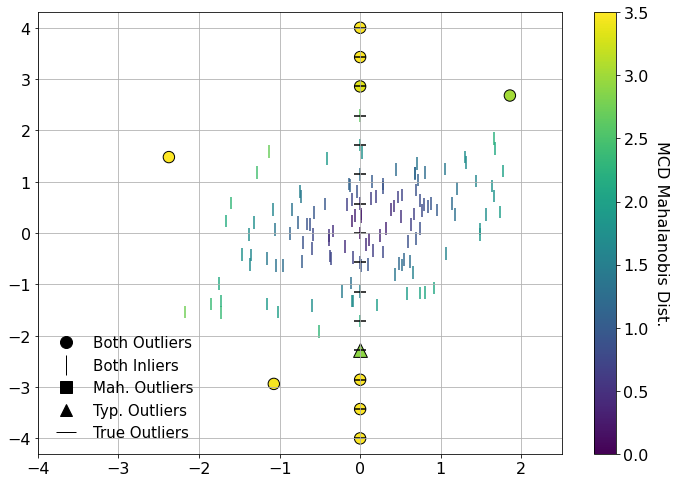

In [16]:
# RESULT EXAMPLE 1
# for consistent results
np.random.seed(42)
# generate Gaussian data of shape (125, 2)
X = multivariate_normal.rvs(mean=np.array([0,0]), cov=gen_cov, size=n_samples)
# add some outliers
outliers = np.zeros((n_outliers,2))
outliers[:,0] = 0
outliers[:,1] = np.linspace(-4, 4, n_outliers)
X[-n_outliers:] = outliers

# COMPUTE TYPICALITY
hi, lo, px = typicality(X, typ_epsilon)
X_col = (px >= lo) & (px <= hi)
X_col = X_col == 1
typ_outliers = X_col==False
typ_inliers = X_col==True   # need both in and out because typicality specifies a band

# COMPUTE MAHALANOBIS
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
m_dists = np.sqrt(robust_cov.dist_)
mah_outliers = m_dists > mah_epsilon

plot(X, mah_outliers, typ_outliers, typ_inliers, filename='mah_v_typ_1.png')